# Automotive industry sites

In [1]:
import geopandas
import pandas as pd
import numpy as np
import pyproj
from shapely.ops import transform

#%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib, descartes
import matplotlib.cm as cm
from matplotlib.offsetbox import AnchoredText

from pynsee import *

In [2]:
# get activity list
naf5 = get_activity_list('NAF5')

# search data in SIRENE database
data = search_sirene(variable = "activitePrincipaleEtablissement",
                   pattern = '29.10Z', kind = 'siret', number=2000)

This function may return personal data, please check and comply with the legal framework relating to personal data protection !


In [3]:
data.to_csv('sirene.csv')

In [4]:
data.head()

,siren,nic,siret,dateDebut,dateCreationEtablissement,dateCreationUniteLegale,dateFin,denominationUniteLegale,nomUniteLegale,prenomUsuelUniteLegale,...,changementEnseigneEtablissement,denominationUsuelleEtablissement,changementDenominationUsuelleEtablissement,nomenclatureActivitePrincipaleEtablissement,changementActivitePrincipaleEtablissement,caractereEmployeurEtablissement,changementCaractereEmployeurEtablissement,libelleCommuneEtranger2Etablissement,codePaysEtranger2Etablissement,libellePaysEtranger2Etablissement
0,006580195,00011,00658019500011,2008-01-01,1965-01-01,1965-01-01,None,SOCIETE INDUSTRIELLE POUR LE DEVELOPPEMENT DE ...,None,None,...,False,None,False,NAFRev2,True,O,False,None,None,None
1,085520195,00109,08552019500109,2022-09-01,2022-06-30,1955-01-01,None,SAFRA,None,None,...,False,None,False,NAFRev2,True,O,False,None,None,None
2,301692307,00020,30169230700020,2020-12-31,2014-08-15,1965-01-01,None,GARAGE BEYRIS,None,None,...,False,None,False,NAFRev2,True,N,False,None,None,None
3,302099890,00014,30209989000014,2023-10-31,1975-01-01,1975-01-01,None,None,IPERTI,JEAN,...,False,None,False,NAFRev2,False,N,True,None,None,None
4,302279229,00025,30227922900025,2014-07-25,1900-01-01,1975-01-01,None,RAPIDO,None,None,...,False,RAPIDO-ESTEREL-ITINEO-CAMPEREVE-DREAMER,True,NAFRev2,False,O,False,None,None,None


In [5]:
# keep only businesses with more then 100 employees
df = data.loc[data['effectifsMinEtablissement'] > 100]
df = df.reset_index(drop=True)
# find latitude and longitude of all businesses
df = df.get_location()

Getting location: 100%|██████████| 51/51 [00:00<00:00, 241.51it/s]


In [6]:
# make geodataframe
gdf = gdf.reset_index(drop=True)
gdf = gdf.sort_values(by=['effectifsMinEtablissement'], ascending=False)

In [7]:
# get map - departement limits
geodataList =  get_geodata_list()
mapdep = get_geodata('ADMINEXPRESS-COG-CARTO.LATEST:departement', update=True)
mapdep = mapdep.transform_overseas()
mapdepgeo.head()

,id,nom_m,nom,insee_dep,insee_reg,geometry,crsCoord
0,DEPARTEM_GLP_00000000001,GUADELOUPE,Guadeloupe,971,01,"MULTIPOLYGON (((-739144.768 6296095.811, -7391...",EPSG:3857
1,DEPARTEM_MTQ_00000000001,MARTINIQUE,Martinique,972,02,"MULTIPOLYGON (((-756752.387 6056818.795, -7567...",EPSG:3857
2,DEPARTEM_REU_00000000001,LA REUNION,La Réunion,974,04,"MULTIPOLYGON (((-807376.954 5867965.281, -8072...",EPSG:3857
3,DEPARTEM_GUF_00000000001,GUYANE,Guyane,973,03,"MULTIPOLYGON (((-650783.613 5681770.336, -6507...",EPSG:3857
4,DEPARTEM_MYT_00000000001,MAYOTTE,Mayotte,976,06,"MULTIPOLYGON (((-553726.624 5453062.725, -5537...",EPSG:3857


In [8]:
# make cleaned labels
match_list = ['RENAULT SAS', 'ALPINE', 'BATILLY', 'MAUBEUGE CONSTRUCTION',
              'TOYOTA', 'STELLANTIS AUTO SAS', 'RENAULT TRUCKS']
other_string_list = '|'.join(['[^' + x + ']' for x in match_list])

conditions = [gdf['denominationUniteLegale'].str.contains(x) for x in match_list]
conditions += [gdf['denominationUniteLegale'].str.contains(other_string_list)]

values = ['RENAULT SAS', 'RENAULT SAS', 'RENAULT SAS', 'RENAULT SAS',
          'TOYOTA', 'STELLANTIS AUTO SAS', 'RENAULT TRUCKS', 'OTHER']

gdf['label'] = np.select(conditions, values)

In [9]:
def _convert_polygon(geo, crs_in='EPSG:4326', crs_out='EPSG:3857'):

    if geo is not None:
        crsIn = pyproj.CRS(crs_in)
        crsOut = pyproj.CRS(crs_out)

        project = pyproj.Transformer.from_crs(crsIn, crsOut, always_xy=True).transform
        geo_converted = transform(project, geo)

        return geo_converted

# convert openstreetmap data from crs 4326 to crs 3857
gdf['geometry'] = gdf['geometry'].apply(lambda x: _convert_polygon(x))

gdf["crs"] = 'EPSG:3857'

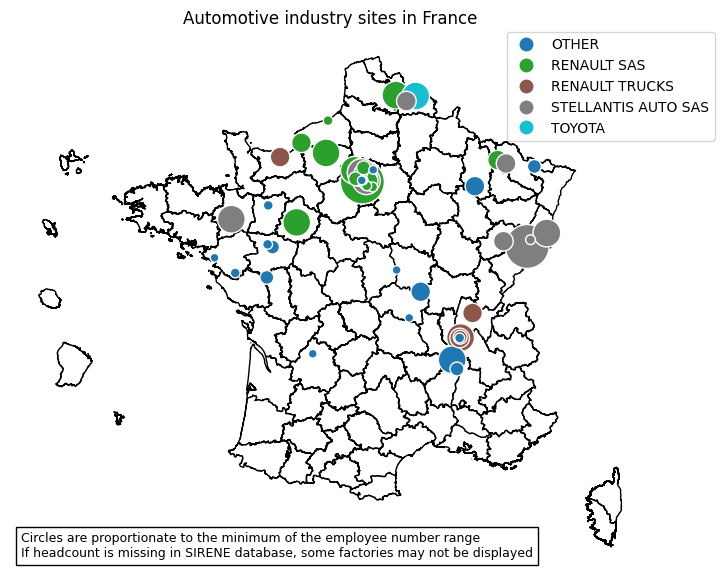

In [10]:
# annotation
txt = 'Circles are proportionate to the minimum of the employee number range'
txt += '\nIf headcount is missing in SIRENE database, some factories may not be displayed'

#plot
ax = mapdepgeo.plot(color='white', edgecolor='black', figsize = (15,7))
plt.title('Automotive industry sites in France')
gdf.plot(ax=ax,
         column = 'label',
         edgecolor='white',
         markersize=gdf.effectifsMinEtablissement/5,
         legend=True,
         legend_kwds={'bbox_to_anchor': (1.1,1),
                       'loc':1, 'borderaxespad': 0})

at = AnchoredText(txt, prop=dict(size=9), frameon=True, loc='lower left')
ax.add_artist(at)
ax.set_axis_off()
plt.show()

In [11]:
gdf.rename(columns={'siren' : 'SIREN'})

,SIREN,nic,siret,dateDebut,dateCreationEtablissement,dateCreationUniteLegale,dateFin,denominationUniteLegale,nomUniteLegale,prenomUsuelUniteLegale,...,latitude,longitude,category,crsCoord,type,importance,exact_location,geometry,label,crs
14,542065479,00140,54206547900140,2008-01-01,1998-12-31,1954-01-01,None,STELLANTIS AUTO SAS,None,None,...,47.513309,6.835445,highway,EPSG:4326,primary,0.100010,True,POINT (760918.234 6026265.337),STELLANTIS AUTO SAS,EPSG:3857
41,780129987,03575,78012998703575,2008-01-01,1999-01-01,1900-01-01,None,RENAULT SAS,None,None,...,48.755422,2.075766,highway,EPSG:4326,tertiary,0.100010,True,POINT (231073.170 6233463.094),RENAULT SAS,EPSG:3857
15,542065479,00181,54206547900181,2008-01-01,1998-12-31,1954-01-01,None,STELLANTIS AUTO SAS,None,None,...,48.043241,-1.708237,boundary,EPSG:4326,administrative,NaN,False,POINT (-190160.062 6114051.547),STELLANTIS AUTO SAS,EPSG:3857
17,542065479,00272,54206547900272,2008-01-01,1998-12-31,1954-01-01,None,STELLANTIS AUTO SAS,None,None,...,47.775299,7.405166,highway,EPSG:4326,service,0.075010,True,POINT (824339.342 6069553.658),STELLANTIS AUTO SAS,EPSG:3857
16,542065479,00215,54206547900215,2008-01-01,1998-12-31,1954-01-01,None,STELLANTIS AUTO SAS,None,None,...,48.780950,2.190005,boundary,EPSG:4326,administrative,NaN,False,POINT (243790.264 6237774.529),STELLANTIS AUTO SAS,EPSG:3857
38,780129987,01892,78012998701892,2008-01-01,1900-01-01,1900-01-01,None,RENAULT SAS,None,None,...,48.977517,1.846397,highway,EPSG:4326,unclassified,0.100010,True,POINT (205539.974 6271047.445),RENAULT SAS,EPSG:3857
37,780129987,01124,78012998701124,2008-01-01,1900-01-01,1900-01-01,None,RENAULT SAS,None,None,...,50.382149,3.045206,boundary,EPSG:4326,administrative,NaN,False,POINT (338990.759 6512722.277),RENAULT SAS,EPSG:3857
22,542065479,00686,54206547900686,2008-02-03,1998-12-31,1954-01-01,None,STELLANTIS AUTO SAS,None,None,...,NaN,NaN,None,EPSG:4326,None,NaN,False,None,STELLANTIS AUTO SAS,EPSG:3857
25,542065479,00926,54206547900926,2008-01-01,2002-06-03,1954-01-01,None,STELLANTIS AUTO SAS,None,None,...,48.933776,2.043911,place,EPSG:4326,house,0.000010,True,POINT (227527.132 6263632.028),STELLANTIS AUTO SAS,EPSG:3857
20,542065479,00322,54206547900322,2008-01-01,1998-12-31,1954-01-01,None,STELLANTIS AUTO SAS,None,None,...,48.935383,2.044069,highway,EPSG:4326,tertiary,0.100010,True,POINT (227544.776 6263904.413),STELLANTIS AUTO SAS,EPSG:3857
